In [1]:
import pandas as pd
import numpy as np
import os
import re
import sklearn
from pathlib import Path
from langdetect import detect_langs

import seaborn as sns
from matplotlib import pyplot as plt

df = pd.read_csv("../tos_data/tos_data.csv", error_bad_lines=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Length    324 non-null    int64 
 1   Link      324 non-null    object
 2   Original  322 non-null    object
dtypes: int64(1), object(2)
memory usage: 7.7+ KB


In [2]:
def remove_multiple_space(sentence):
    clear_sentence = ' '.join(sentence.split())
    #clear_sentence = clear_sentence.lower()
    return clear_sentence

df_raw = df[df['Length'] > 300] # Deleting a HTML's text that was not properly collected.
df_raw['Original'] = df_raw['Original'].astype(str)
df_raw = df_raw.drop_duplicates(['Original'])
df_raw['Original'] = df_raw['Original'].apply(remove_multiple_space)
df_raw.describe(include=object)

<ipython-input-2-1bb8b5900bb7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw['Original'] = df_raw['Original'].astype(str)


,Link,Original
count,307,307
unique,307,307
top,https://www.happeo.com/tos,Terms of Service - Legal | OVHcloud Skip to ma...
freq,1,1


In [3]:
from spacy.language import Language
import spacy
nlp = spacy.load("en_core_web_sm") # load pre-trained NLP model for sentence segmentation.

df_raw = df_raw.drop(columns=['Length'])

@Language.component("set_custom_boundaries")
def set_custom_boundaries(doc):
    for token in doc[:-1]:
        if token.text == ";":
            doc[token.i + 1].is_sent_start = True
    return doc

def filter_roman_number(s):
    result = []
    for t in s:
        t_result = re.split(r'\(.\) | \(..\) | \(...\) | \(....\)', t)
        result = result + t_result
        
    result = list(filter(None, result))  
    return result

def make_new_row(plist, df_raw_parsed):
    for s in plist:
        new_row = {
            'Link': row['Link'],
            'Original': s,
        }
        df_raw_parsed = df_raw_parsed.append(new_row, ignore_index=True)
    return df_raw_parsed

nlp.add_pipe("set_custom_boundaries", before="parser")
df_raw_parsed = pd.DataFrame(columns=['Link', 'Original'])
for i, row in df_raw.iterrows():
    t_list = [sent.text for sent in nlp(row['Original']).sents]
    f_list = filter_roman_number(t_list)

    if not f_list:
        df_raw_parsed = make_new_row(t_list, df_raw_parsed)
    else:
        df_raw_parsed = make_new_row(f_list, df_raw_parsed)

In [4]:
df_raw_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90234 entries, 0 to 90233
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Link      90234 non-null  object
 1   Original  90234 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


In [5]:
df_raw_parsed['Length'] = df_raw_parsed['Original'].apply(lambda x: len(x)) # Create new 'Length' column.
df_raw_parsed = df_raw_parsed[['Length', 'Link', 'Original']]
df_raw_parsed = df_raw_parsed[df_raw_parsed['Length'] > 50]

In [6]:
df_raw_parsed.describe(include=object)

,Link,Original
count,68367,68367
unique,307,62389
top,http://www.three.co.uk/terms-conditions,"By submitting an entry, entrants will be deeme..."
freq,6055,41


In [7]:
df_raw_parsed['Original'] = df_raw_parsed['Original'].astype(str)
df_raw_parsed = df_raw_parsed.drop_duplicates(['Original']) # Remove duplicate data. Remain unique data in column.
df_raw_parsed.describe(include=object)

,Link,Original
count,62389,62389
unique,307,62389
top,https://www.playtika.com/terms-service/,Administrators to have the access described in...
freq,4055,1


In [8]:
def detect_english_sentence(sentence):
    try:
        res = detect_langs(sentence)
        for item in res:
            if item.lang == "en" and item.prob > 0.99:
                return True
            else:
                return False
    except:
        return False

def make_space(sentence):
    result =[]
    # Insert a space such as "HelloWorld" -> "Hello World"
    result = re.sub(r"([a-z])([A-Z])([a-z])", r"\1 \2\3", sentence)
    return result

for i, row in df_raw_parsed.iterrows():
    if detect_english_sentence(row['Original']) == True:
        result = make_space(row['Original'])
    else:
        result = ""
    df_raw_parsed.loc[i, 'Original'] = result

In [9]:
df_raw_parsed = df_raw_parsed.reset_index(drop=True)
df_raw_parsed = df_raw_parsed[df_raw_parsed['Original'] != '']
df_raw_parsed.to_csv(Path(os.getcwd() + "/" + "test_tos_data.csv"), index=False) 

In [10]:
# Compare data that calculated length of whole sentence each pandas.
# Through this, you can see how much data is lost after parsing.

# df_raw = df_raw[df_raw['Original'] != '']
# df_raw['Original'] = df_raw['Original'].astype(str)
# df_raw = df_raw.drop_duplicates(['Original'])

# sum_df_raw = 0
# sum_df_raw_parsed = 0

# for i, row in df_raw.iterrows():
#     sum_df_raw = sum_df_raw + len(row['Original'])

# for i, row in df_raw_parsed.iterrows():
#     sum_df_raw_parsed = sum_df_raw_parsed + len(row['Original'])

# print('Before text parsing {0}, After text parsing {1}'.format(sum_df_raw, sum_df_raw_parsed))

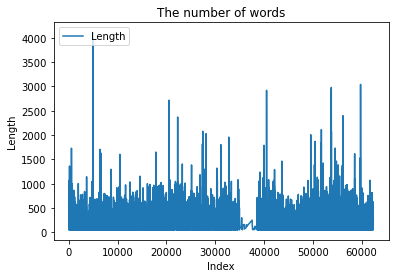

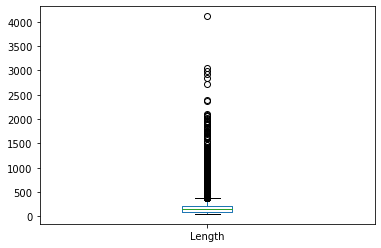

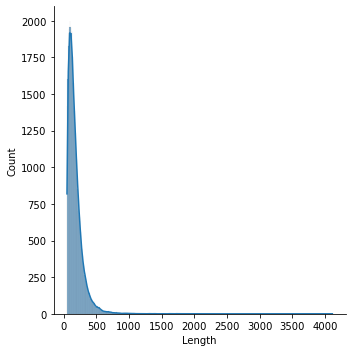

In [10]:
plt.title("The number of words")
plt.xlabel("Index")
plt.ylabel("Length")
plt.plot(df_raw_parsed.index, df_raw_parsed['Length'].values, label='Length')
plt.legend(loc='upper left')
plt.show()
df_raw_parsed.plot(kind='box', figsize=(6,4))
sns.displot(df_raw_parsed['Length'], kde=True)
# Reference: https://datascienceschool.net/01%20python/05.04%20%EC%8B%9C%EB%B3%B8%EC%9D%84%20%EC%82%AC%EC%9A%A9%ED%95%9C%20%EB%8D%B0%EC%9D%B4%ED%84%B0%20%EB%B6%84%ED%8F%AC%20%EC%8B%9C%EA%B0%81%ED%99%94.html

In [11]:
df_raw_parsed.describe(exclude=object)

,Length
count,57216.000000
mean,175.857365
std,126.349582
min,51.000000
25%,99.000000
50%,144.000000
75%,214.000000
max,4113.000000


In [12]:
df_heuristics = pd.read_csv("test_tos_data.csv", error_bad_lines=False)
df_heuristics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56667 entries, 0 to 56666
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Length    56667 non-null  int64 
 1   Link      56667 non-null  object
 2   Original  56667 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


In [13]:
df_heuristics = df_heuristics.sort_values(by='Length') # data sorted by descending order.
df_heuristics = df_heuristics.reset_index(drop=True)
df_heuristics

,Length,Link,Original
0,51,https://www.roposo.com/tnc,Your contact information (email address prefer...
1,51,https://www.facebook.com/terms.php,We reserve all rights not expressly granted to...
2,51,https://www.ukg.com/terms-of-use,The following activities are expressly prohibi...
3,51,https://www.pressganey.com/terms-service,as such Users are expected to act as professio...
4,51,https://www.myvi.in/terms-of-use,or any other document signed by you in this re...
...,...,...,...
56662,2836,https://auspost.com.au/terms-conditions,Satchels & packaging Arrow to indicate more li...
56663,2920,https://www.sgs.com/en/terms-and-conditions,Visit the US website instead Stay on the globa...
56664,2979,https://auspost.com.au/terms-conditions,Satchels & packaging Arrow to indicate more li...
56665,3041,https://www.myntra.com/termsofuse,User Conduct and Rules on the Platform:You agr...


In [14]:
np.percentile(df_heuristics['Length'], [5, 95], interpolation='nearest') # For readability, extract sentences based on 5%ile, 95%ile.

array([ 62, 386], dtype=int64)

In [15]:
df_heuristics = df_heuristics[(df_heuristics['Length'] >= 62) & (df_heuristics['Length'] <= 386)]
df_heuristics

,Length,Link,Original
2703,62,https://www.jampp.com/privacy-policy-terms-and...,"You may review, correct or delete your persona..."
2704,62,https://legal.ubi.com/termsofuse/,We reserve the right to refuse any password at...
2705,62,https://www.ge.com/power/terms-conditions,User Conduct - Online Communities and Other In...
2706,62,http://www.three.co.uk/terms-conditions,Cookies can be read by the web site on your su...
2707,62,http://www.three.co.uk/terms-conditions,Rewards are non-transferable and there is no c...
...,...,...,...
53842,386,https://www.lyft.com/terms,"However, if you are the party initiating the D..."
53843,386,https://www.facebook.com/terms.php,"To help advance this mission, we provide the P..."
53844,386,https://www.copyright.com/sow-terms-conditions...,months following termination or expiry of this...
53845,386,https://terms.maersk.com/,Back to top General Business Terms for Carriag...


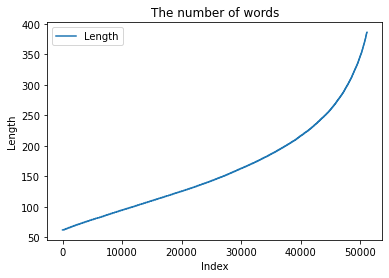

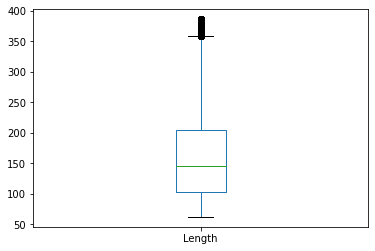

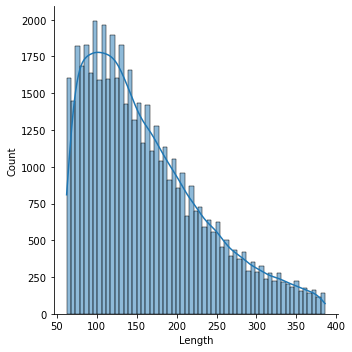

In [16]:
df_heuristics = df_heuristics.reset_index(drop=True)

plt.title("The number of words")
plt.xlabel("Index")
plt.ylabel("Length")
plt.plot(df_heuristics.index, df_heuristics['Length'].values, label='Length')
plt.legend(loc='upper left')
plt.show()
df_heuristics.plot(kind='box', figsize=(6,4))
sns.displot(df_heuristics['Length'], kde=True)

In [17]:


df_mturk = sklearn.utils.shuffle(df_heuristics)
#df_mturk.to_csv(Path(os.getcwd() + "/" + "mturk_tos_data_include_length.csv"), index=False)
df_mturk = df_mturk.drop(columns=['Length'])
df_mturk.to_csv(Path(os.getcwd() + "/" + "mturk_tos_data.csv"), index=False)